<a href="https://colab.research.google.com/github/gitHubAndyLee2020/ExchangeGPT/blob/main/stock_exchange_traditional_rl_agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Stock Exchange Project Traditional RL Agents



In [ ]:
!pip install gym-anytrading stable-baselines3 huggingface_sb3

In [77]:
from tqdm import tqdm
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import gymnasium as gym
import gym_anytrading

from stable_baselines3 import A2C, PPO
from stable_baselines3.common.callbacks import BaseCallback

import torch

In [13]:
env_id = "stocks-v0"

df = gym_anytrading.datasets.STOCKS_GOOGL.copy()

window_size = 10
start_index = window_size
end_index = len(df)

env = gym.make(
    env_id,
    df=df,
    window_size=window_size,
    frame_bound=(start_index, end_index)
)

print("observation_space:", env.observation_space)

observation_space: Box(-10000000000.0, 10000000000.0, (10, 2), float32)


In [14]:
def print_stats(reward_over_episodes):
    """  Print Reward  """

    avg = np.mean(reward_over_episodes)
    min = np.min(reward_over_episodes)
    max = np.max(reward_over_episodes)

    print (f'Min. Reward          : {min:>10.3f}')
    print (f'Avg. Reward          : {avg:>10.3f}')
    print (f'Max. Reward          : {max:>10.3f}')

    return min, avg, max


# ProgressBarCallback for model.learn()
class ProgressBarCallback(BaseCallback):

    def __init__(self, check_freq: int, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        self.progress_bar = tqdm(total=self.model._total_timesteps, desc="model.learn()")

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            self.progress_bar.update(self.check_freq)
        return True

    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        self.progress_bar.close()


# TRAINING + TEST
def train_test_model(model, env, seed, total_num_episodes, total_learning_timesteps=10_000):
    """ if model=None then execute 'Random actions' """

    # reproduce training and test
    print('-' * 80)
    obs = env.reset(seed=seed)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    vec_env = None

    if model is not None:
        print(f'model {type(model)}')
        print(f'policy {type(model.policy)}')
        # print(f'model.learn(): {total_learning_timesteps} timesteps ...')

        # custom callback for 'progress_bar'
        model.learn(total_timesteps=total_learning_timesteps, callback=ProgressBarCallback(100))
        # model.learn(total_timesteps=total_learning_timesteps, progress_bar=True)
        # ImportError: You must install tqdm and rich in order to use the progress bar callback.
        # It is included if you install stable-baselines with the extra packages: `pip install stable-baselines3[extra]`

        vec_env = model.get_env()
        obs = vec_env.reset()
    else:
        print ("RANDOM actions")

    reward_over_episodes = []

    tbar = tqdm(range(total_num_episodes))

    for episode in tbar:

        if vec_env:
            obs = vec_env.reset()
        else:
            obs, info = env.reset()

        total_reward = 0
        done = False

        while not done:
            if model is not None:
                action, _states = model.predict(obs)
                obs, reward, done, info = vec_env.step(action)
            else: # random
                action = env.action_space.sample()
                obs, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated

            total_reward += reward
            if done:
                break

        reward_over_episodes.append(total_reward)

        if episode % 10 == 0:
            avg_reward = np.mean(reward_over_episodes)
            tbar.set_description(f'Episode: {episode}, Avg. Reward: {avg_reward:.3f}')
            tbar.update()

    tbar.close()
    avg_reward = np.mean(reward_over_episodes)

    return reward_over_episodes

# TEST ONLY
def test_model(model, env, total_num_episodes, deterministic=False):
    """Test a trained model or execute 'Random actions' if model is None."""

    reward_over_episodes = []

    for episode in tqdm(range(total_num_episodes), desc="Testing"):
        obs = env.reset()
        total_reward = 0
        done = False

        while not done:
            if model is not None:
                # Using the model to predict the action
                action, _states = model.predict(obs, deterministic=deterministic)
                action = [action]  # Ensure action is in the correct format
            else:
                # Random actions
                action = [env.action_space.sample()]

            obs, rewards, dones, infos = env.step(action)
            reward = rewards[0]  # Extract the scalar reward value
            done = dones[0]  # Extract the scalar done value
            total_reward += reward

        reward_over_episodes.append(total_reward)

    return reward_over_episodes

In [ ]:
seed = 42  # random seed
total_num_episodes = 50 # Switch to 50 during production, use 2 during testing to reduce runtime

print ("env_name                 :", env_id)
print ("seed                     :", seed)

# INIT matplotlib
plot_settings = {}
plot_data = {'x': [i for i in range(1, total_num_episodes + 1)]}

# Random actions
model = None
total_learning_timesteps = 0
rewards = train_test_model(model, env, seed, total_num_episodes, total_learning_timesteps)
min, avg, max = print_stats(rewards)
class_name = f'Random actions'
label = f'Avg. {avg:>7.2f} : {class_name}'
plot_data['rnd_rewards'] = rewards
plot_settings['rnd_rewards'] = {'label': label}

# Specify the learning time steps here
learning_timesteps_list_in_K = [25, 50, 100, 200]

# RL Algorithms: https://stable-baselines3.readthedocs.io/en/master/guide/algos.html
model_class_list = [A2C, PPO]
models = {}

for timesteps in learning_timesteps_list_in_K:
    total_learning_timesteps = timesteps * 1000
    step_key = f'{timesteps}K'

    for model_class in model_class_list:
        policy_dict = model_class.policy_aliases
        # https://stable-baselines3.readthedocs.io/en/master/guide/custom_policy.html
        # MlpPolicy or MlpLstmPolicy
        policy = policy_dict.get('MlpPolicy')
        if policy is None:
            policy = policy_dict.get('MlpLstmPolicy')
        # print ('policy:', policy, 'model_class:', model_class)

        try:
            model = model_class(policy, env, verbose=0)
            class_name = type(model).__qualname__
            plot_key = f'{class_name}_rewards_'+step_key
            rewards = train_test_model(model, env, seed, total_num_episodes, total_learning_timesteps)
            min, avg, max, = print_stats(rewards)
            label = f'Avg. {avg:>7.2f} : {class_name} - {step_key}'
            plot_data[plot_key] = rewards
            plot_settings[plot_key] = {'label': label}
            if timesteps not in models.keys():
                models[timesteps] = {}
            models[timesteps][class_name] = model

        except Exception as e:
            print(f"ERROR: {str(e)}")
            continue

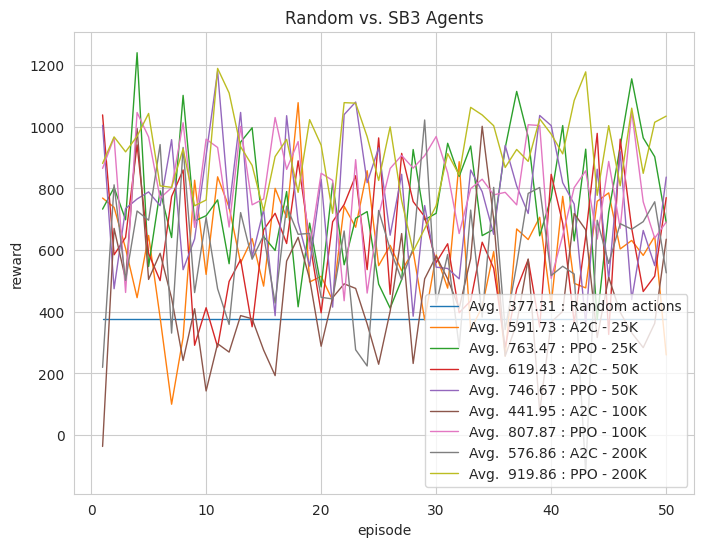

In [79]:
data = pd.DataFrame(plot_data)

sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))

for key in plot_data:
    if key == 'x':
        continue
    label = plot_settings[key]['label']
    line = plt.plot('x', key, data=data, linewidth=1, label=label)

plt.xlabel('episode')
plt.ylabel('reward')
plt.title('Random vs. SB3 Agents')
plt.legend()
plt.show()

In [80]:
for timesteps in models.keys():
    for class_name in models[timesteps].keys():
        model = models[timesteps][class_name]
        model.save(f"{class_name}-{env_id}-{timesteps}K")

In [83]:
import numpy as np
import gymnasium as gym
from stable_baselines3.common.vec_env import DummyVecEnv

class RenderCompatibleEnvWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)

    def render(self, mode='rgb_array'):
        # Assuming a dummy image size of 64x64 with 3 channels (RGB)
        dummy_image = np.zeros((64, 64, 3), dtype=np.uint8)
        return dummy_image

# Wrap your environment
wrapped_env = lambda: RenderCompatibleEnvWrapper(gym.make(
    env_id,
    df=df,
    window_size=window_size,
    frame_bound=(start_index, end_index)
))

# Create the DummyVecEnv with the wrapped environment
eval_env = DummyVecEnv([wrapped_env])

# Set render_mode and training flag
eval_env.render_mode = "rgb_array"
eval_env.training = False

### Saving Models to HuggingFace

In [ ]:
from huggingface_hub import notebook_login
notebook_login()
!git config --global credential.helper store

In [ ]:
from huggingface_sb3 import package_to_hub

for timesteps in models.keys():
    for class_name in models[timesteps].keys():
        model = models[timesteps][class_name]
        package_to_hub(
            model=model,
            model_name=f"{class_name}-{env_id}-{timesteps}K",
            model_architecture=class_name,
            env_id=env_id,
            eval_env=eval_env,
            repo_id=f"techandy42/{class_name}-{env_id}-{timesteps}K",
            commit_message="Initial commit",
        )

### Loading Models from HuggingFace

In [ ]:
import gymnasium as gym

from huggingface_sb3 import load_from_hub
from stable_baselines3 import A2C, PPO

model_class_and_name_list = [(A2C, 'A2C'), (PPO, 'PPO')]
learning_timesteps = [25, 50, 100, 200]

loaded_models = {}

for timesteps in learning_timesteps:
    for model_class, class_name in model_class_and_name_list:
        model_id = f"{class_name}-{env_id}-{timesteps}K"
        print(f"Loading {model_id}...")
        checkpoint = load_from_hub(
            repo_id=f"techandy42/{model_id}",
            filename=f"{model_id}.zip",
        )
        if timesteps not in loaded_models.keys():
            loaded_models[timesteps] = {}
        loaded_models[timesteps][class_name] = model_class.load(checkpoint)

In [100]:
# Create a test vectorized environment for testing all models
test_env = DummyVecEnv([lambda: gym.make(
    env_id,
    df=df,
    window_size=window_size,
    frame_bound=(start_index, end_index)
)])

# Set render_mode and training flag for the testing environment
test_env.render_mode = "rgb_array"
test_env.training = False

In [ ]:
# Evaluate the models and the random policy
total_num_episodes = 50  # Adjust this number as needed
rewards_dict = {}

# Evaluate loaded models
for timesteps in loaded_models.keys():
    for class_name in loaded_models[timesteps].keys():
        model_label = f"{class_name} - {timesteps}K"
        model = loaded_models[timesteps][class_name]
        rewards_dict[model_label] = test_model(model, test_env, total_num_episodes)

# Evaluate random policy
rewards_dict["RandomPolicy"] = test_model(None, test_env, total_num_episodes)

In [ ]:
# Prepare data for plotting
data = pd.DataFrame(rewards_dict)

# Plotting
plt.figure(figsize=(12, 6))

# Plot and annotate each model's performance
for key in rewards_dict:
    mean_reward = np.mean(rewards_dict[key])
    plt.plot(data[key], label=f"{key} (Avg: {mean_reward:.2f})")

plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Performance of Different Policies')
plt.legend()
plt.show()